In [74]:
import pandas as pd
import matplotlib.pyplot as plt


file_path = 'data/regularityTrainData.csv'

# Will not treat the problematic lines

df = pd.read_csv(file_path, on_bad_lines='skip')
df = pd.read_csv(file_path, delimiter=';')


In [75]:
# Get all the columns
column_names = df.columns.tolist()
print(column_names)

['Date', 'Service', 'Gare de départ', "Gare d'arrivée", 'Durée moyenne du trajet', 'Nombre de circulations prévues', 'Nombre de trains annulés', 'Commentaire annulations', 'Nombre de trains en retard au départ', 'Retard moyen des trains en retard au départ', 'Retard moyen de tous les trains au départ', 'Commentaire retards au départ', "Nombre de trains en retard à l'arrivée", "Retard moyen des trains en retard à l'arrivée", "Retard moyen de tous les trains à l'arrivée", "Commentaire retards à l'arrivée", 'Nombre trains en retard > 15min', 'Retard moyen trains en retard > 15 (si liaison concurrencée par vol)', 'Nombre trains en retard > 30min', 'Nombre trains en retard > 60min', 'Prct retard pour causes externes', 'Prct retard pour cause infrastructure', 'Prct retard pour cause gestion trafic', 'Prct retard pour cause matériel roulant', 'Prct retard pour cause gestion en gare et réutilisation de matériel', 'Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, corre

In [76]:
# Ensure the 'Date' column is in datetime format
print(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Extract month from data 
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

#To check that the date has been correctly converted and the month correctly extracted
print(df['Month'])



0       2018-01
1       2018-01
2       2018-01
3       2018-01
4       2018-01
         ...   
8869    2023-12
8870    2023-12
8871    2023-12
8872    2023-12
8873    2023-12
Name: Date, Length: 8874, dtype: object
0        1
1        1
2        1
3        1
4        1
        ..
8869    12
8870    12
8871    12
8872    12
8873    12
Name: Month, Length: 8874, dtype: int64


In [77]:
# We would like to base our predictions on the year 2020-2021-2022-2023 only
# Filter the DataFrame to find rows with dates after 2019
df_after_2019 = df[df['Date'].dt.year > 2019]

# Find the first row in this filtered DataFrame
first_row_after_2019 = df_after_2019.head(1)

# Display the first row
print(first_row_after_2019.index[0])


# Re-shaping the data: as 3036 is the first line containing data from after 2019
df_sliced = df.iloc[first_row_after_2019.index[0]:].copy()


3036


In [78]:
# Re-shaping the data by removing the unnecessary columns 
# Columns to drop
columns_to_drop = [
    "Commentaire annulations",
    "Commentaire retards au départ",
    "Commentaire retards à l'arrivée"
]

# Drop the specified columns from the DataFrame
df_sliced.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

# Get all the remaining columns 
column_names = df_sliced.columns.tolist()
print(column_names)


['Date', 'Service', 'Gare de départ', "Gare d'arrivée", 'Durée moyenne du trajet', 'Nombre de circulations prévues', 'Nombre de trains annulés', 'Nombre de trains en retard au départ', 'Retard moyen des trains en retard au départ', 'Retard moyen de tous les trains au départ', "Nombre de trains en retard à l'arrivée", "Retard moyen des trains en retard à l'arrivée", "Retard moyen de tous les trains à l'arrivée", 'Nombre trains en retard > 15min', 'Retard moyen trains en retard > 15 (si liaison concurrencée par vol)', 'Nombre trains en retard > 30min', 'Nombre trains en retard > 60min', 'Prct retard pour causes externes', 'Prct retard pour cause infrastructure', 'Prct retard pour cause gestion trafic', 'Prct retard pour cause matériel roulant', 'Prct retard pour cause gestion en gare et réutilisation de matériel', 'Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)', 'Month']


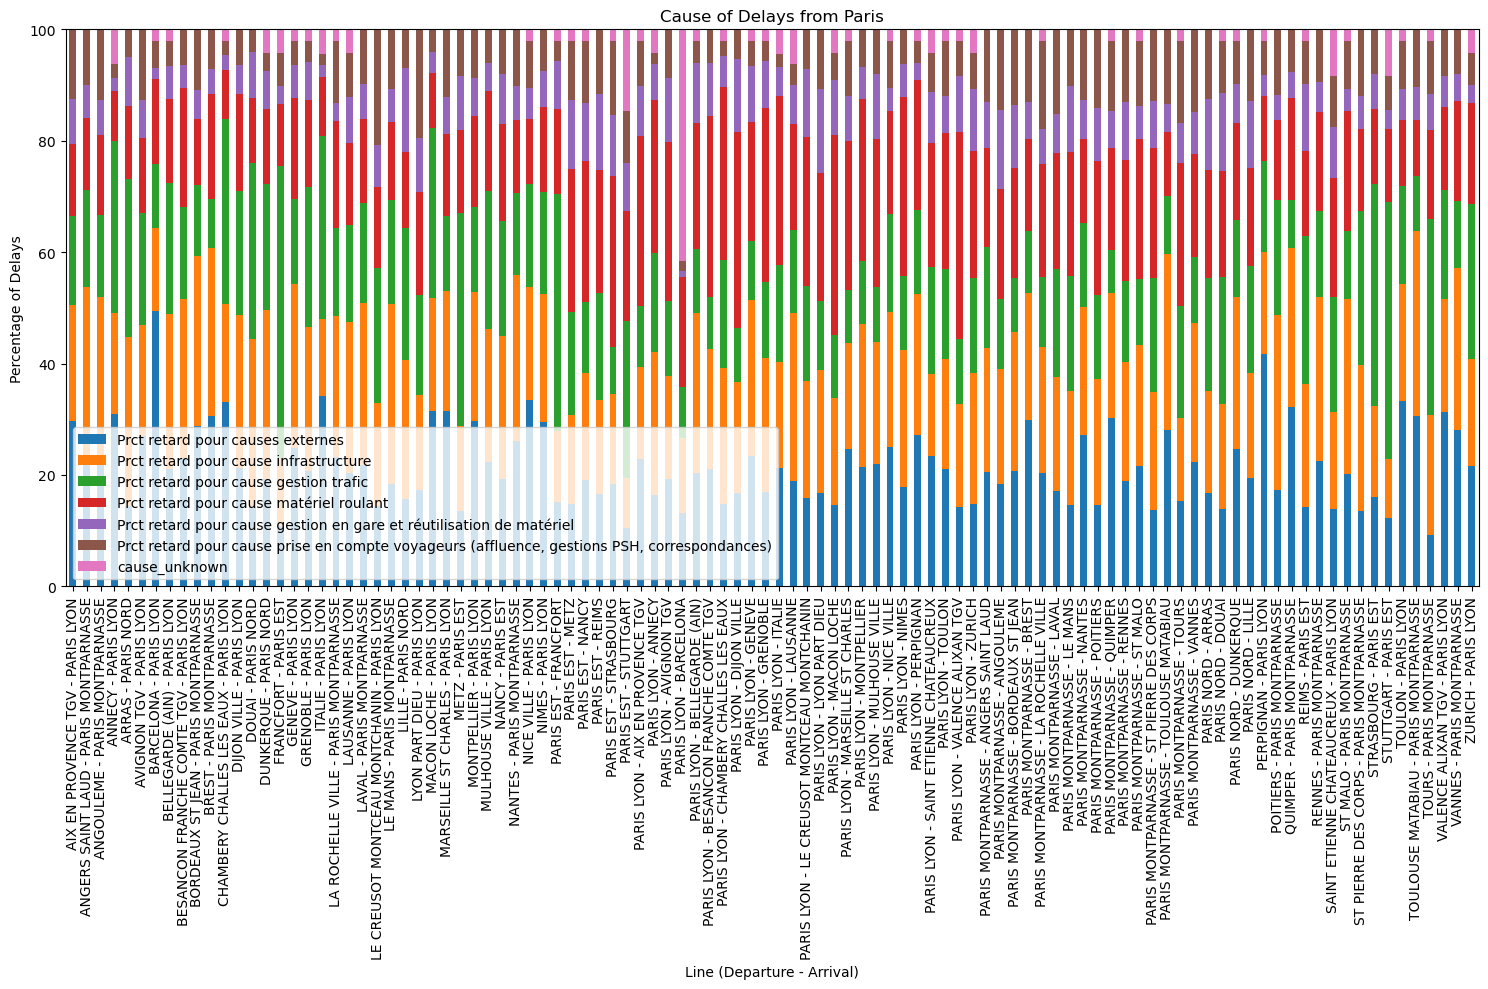

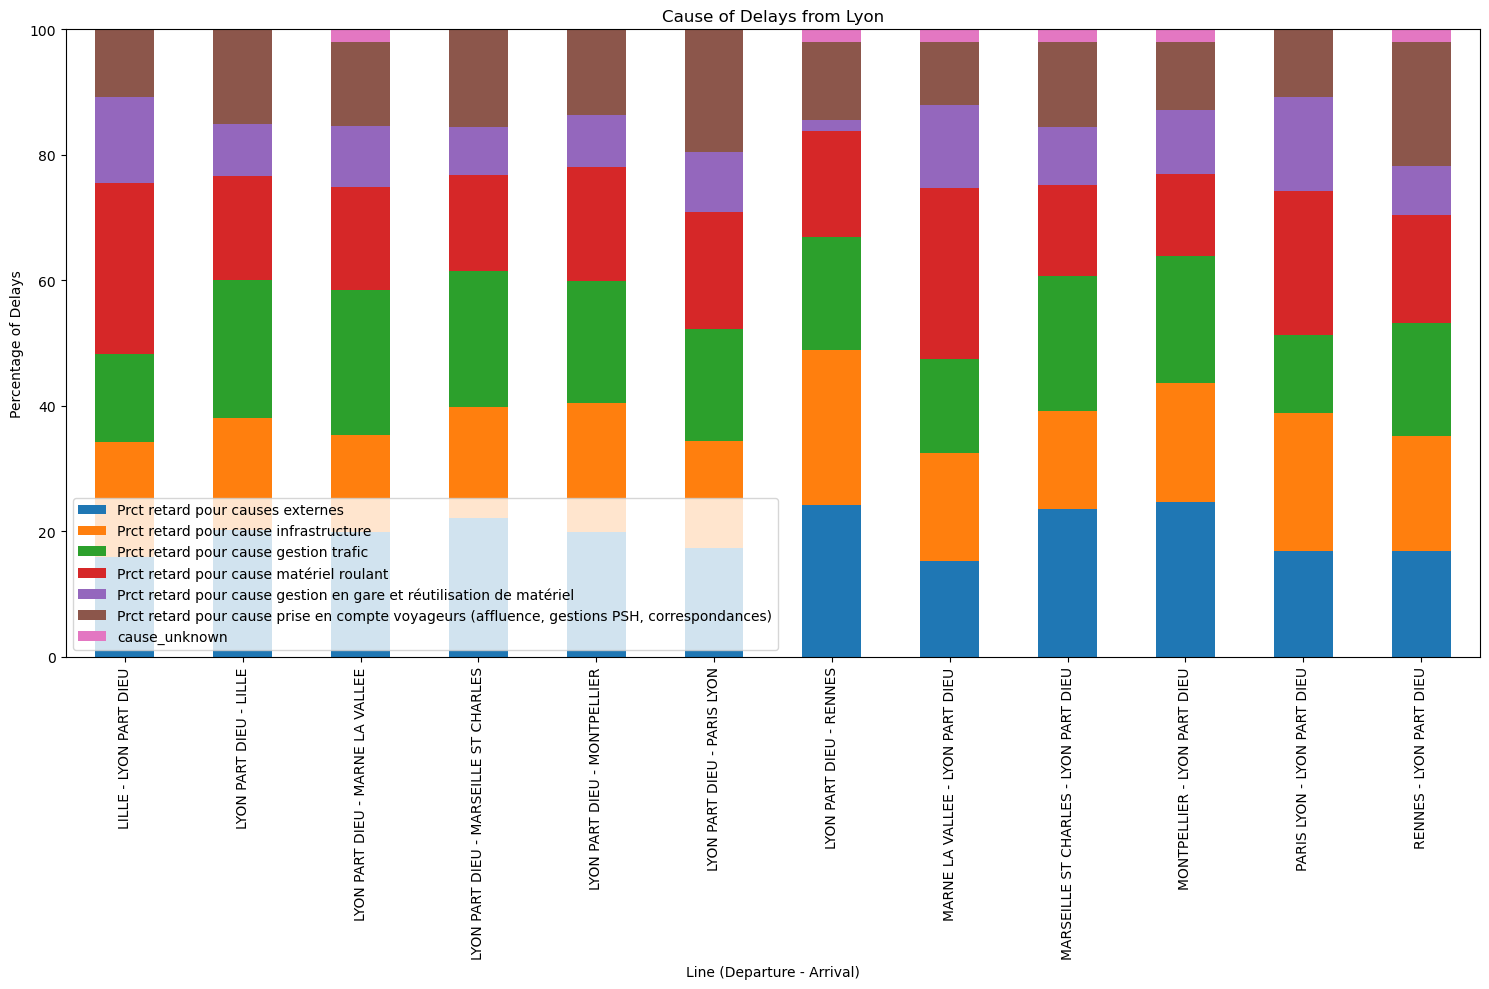

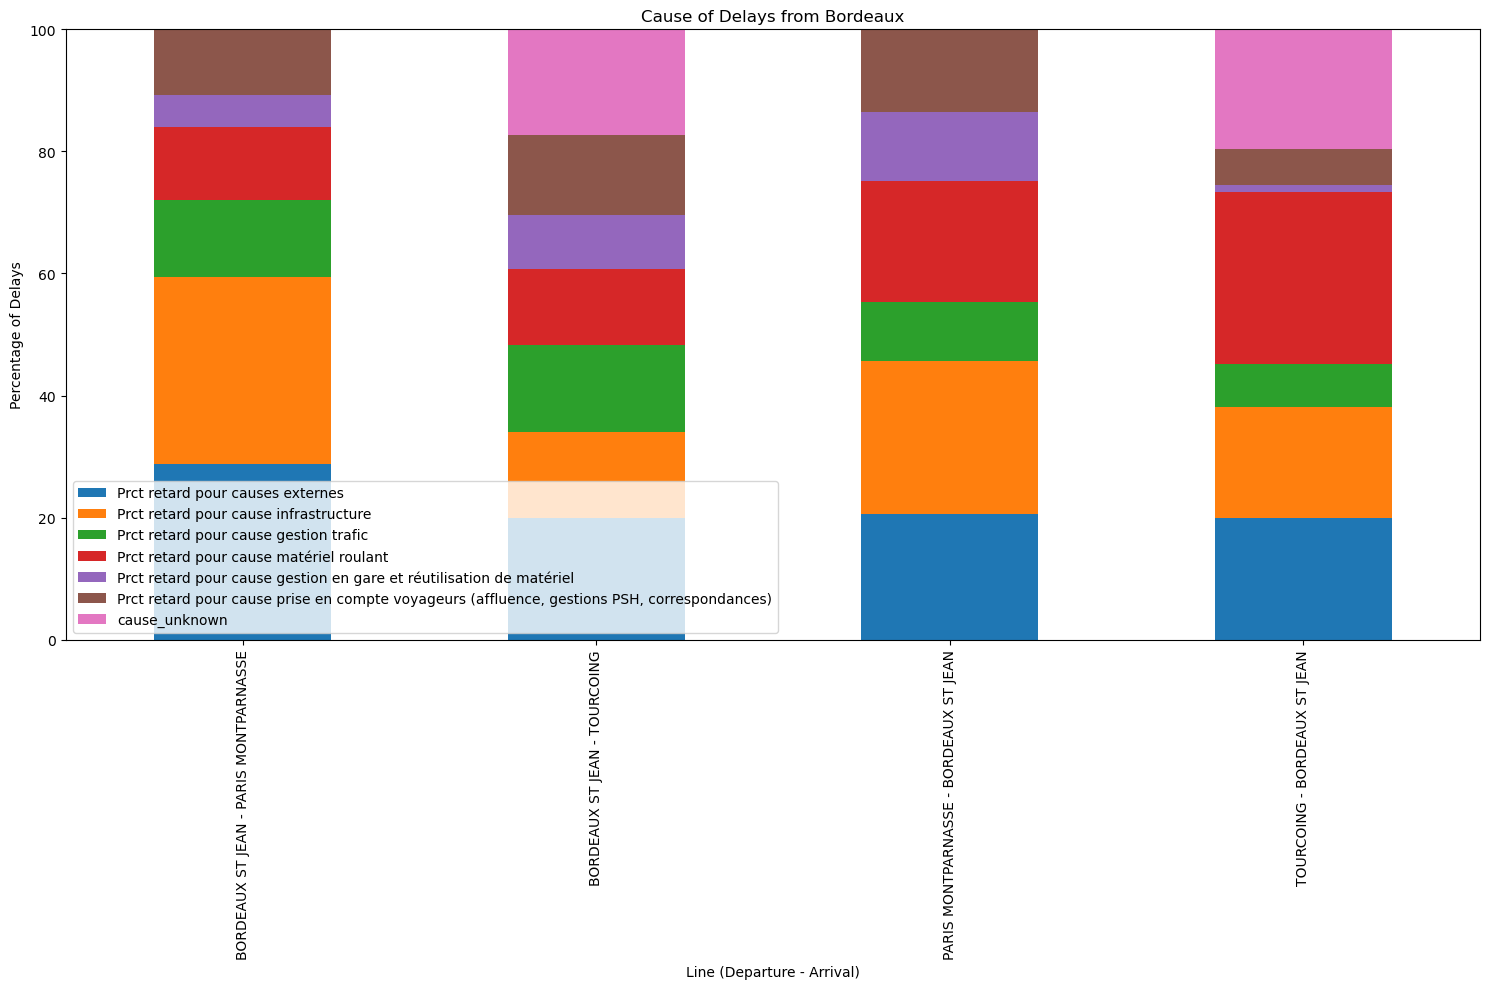

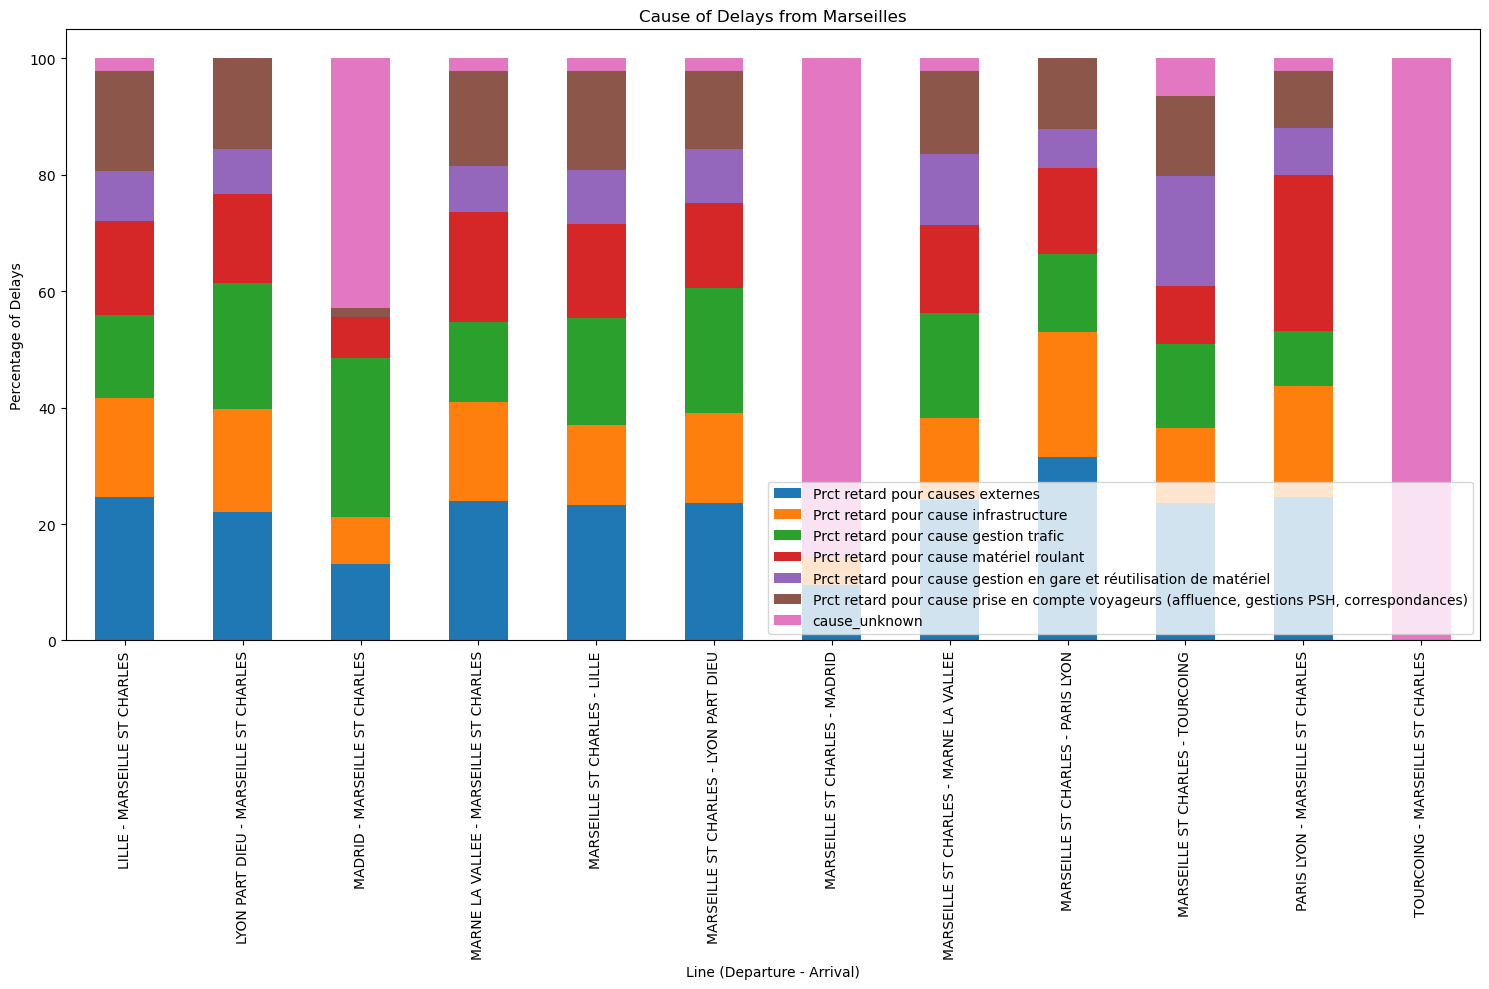

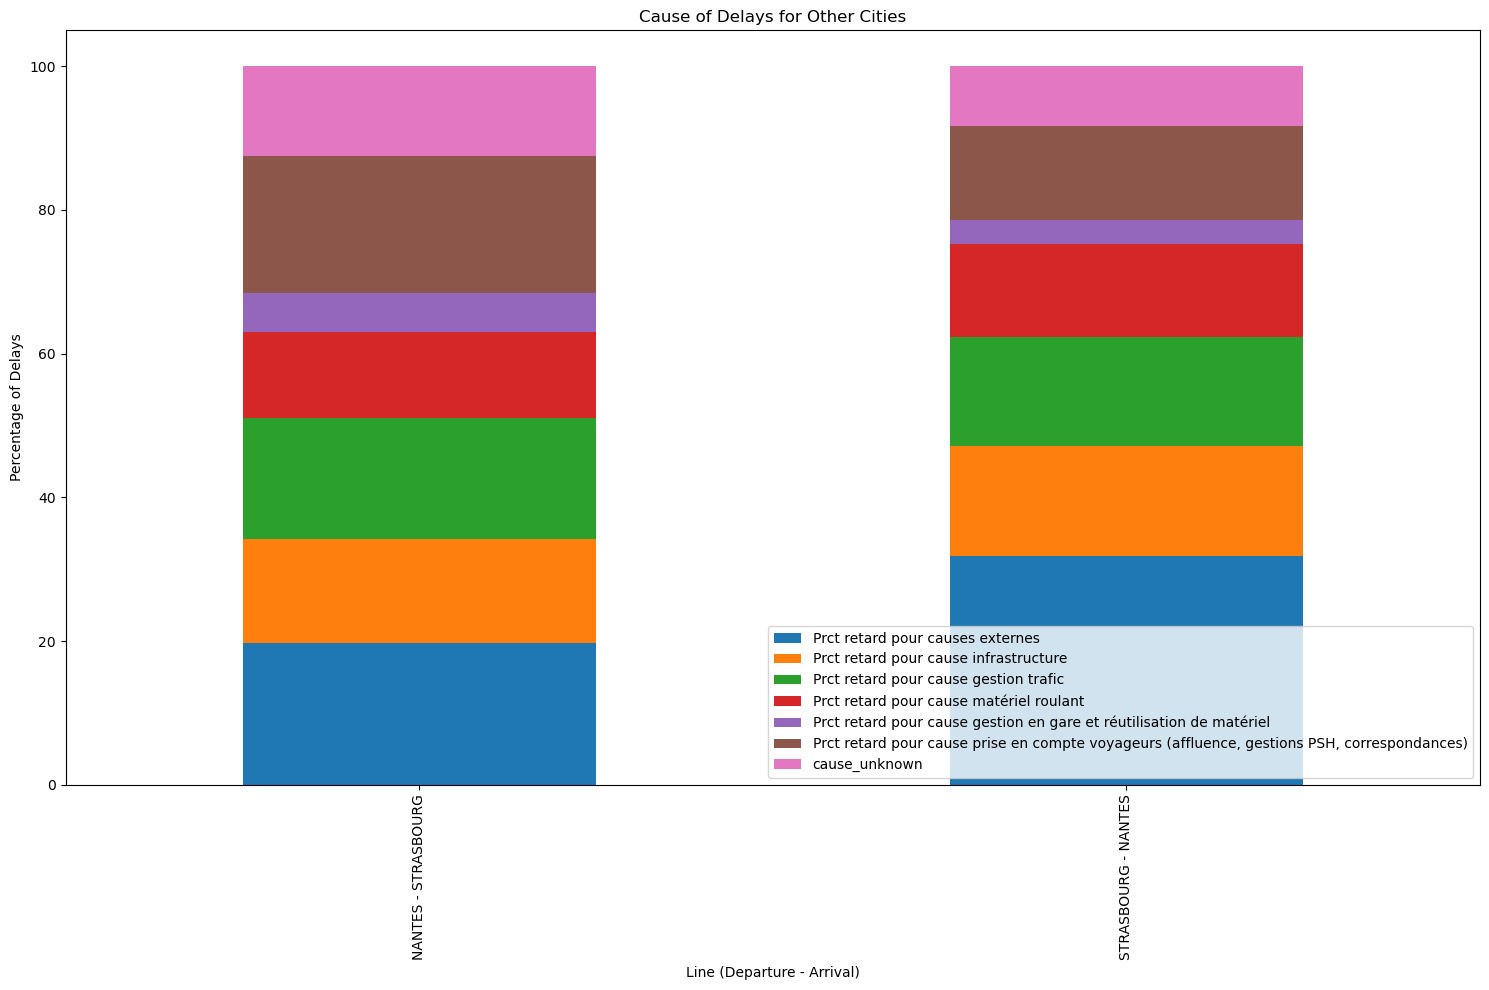

In [80]:
## Represent graphically the cause of the delays for each route 

# Larger figure size
fig_width = 15  # Adjust width as needed
fig_height = 10  # Adjust height as needed


# Create the 'Line' identifier column which will be used to create the different existing "routes" 
df_sliced['Line'] = df_sliced['Gare de départ'] + " - " + df_sliced["Gare d'arrivée"]

# Define the aggregation functions : for the cause of the delay, the mean of the delay is taken over the years for a particular route, independent of the month
agg_functions = {
    'Nombre de trains en retard au départ': 'sum',
    'Prct retard pour causes externes': 'mean',
    'Prct retard pour cause infrastructure': 'mean',
    'Prct retard pour cause gestion trafic' : 'mean', 
    'Prct retard pour cause matériel roulant' : 'mean', 
    'Prct retard pour cause gestion en gare et réutilisation de matériel': 'mean', 
    'Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)' : 'mean'
}



# Define the cities and their corresponding gares (stations) to have a better visual representation
cities = {
    'Paris':  ['PARIS LYON', 'PARIS MONTPARNASSE', 'PARIS EST', 'PARIS NORD'],  # Assuming the presence of 'Paris' in the 'Gare de départ' indicates a Paris station
    'Lyon': ['LYON PART DIEU'], # and so on for other cities
    'Bordeaux' : ['BORDEAUX ST JEAN'],
    'Marseilles' : ['MARSEILLE ST CHARLES']
}


cause_columns = [
    'Prct retard pour causes externes',
    'Prct retard pour cause infrastructure',
    'Prct retard pour cause gestion trafic',
    'Prct retard pour cause matériel roulant',
    'Prct retard pour cause gestion en gare et réutilisation de matériel',
    'Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)'
]



# Aggregate by lines
df_grouped = df_sliced.groupby('Line').agg(agg_functions)

# Now, calculate 'cause_unknown' for each group
df_grouped['cause_unknown'] = 100 - df_grouped[cause_columns].sum(axis=1)

# Ensure 'cause_unknown' doesn't go below 0 (in case of any data issues)
df_grouped['cause_unknown'] = df_grouped['cause_unknown'].clip(lower=0)
cause_columns.append('cause_unknown') 



# Plot for each city
for city, stations in cities.items():
    pattern = '|'.join(stations)  # Pattern to match stations for the current city
    city_df_grouped = df_grouped[df_grouped.index.str.contains(pattern)][cause_columns]
    
    if not city_df_grouped.empty:
        city_df_grouped.plot(kind='bar', stacked=True, figsize=(fig_width, fig_height))
        plt.title(f'Cause of Delays from {city}')
        plt.xlabel('Line (Departure - Arrival)')
        plt.ylabel('Percentage of Delays')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No delay cause data to plot for {city}")

# Correctly filter for 'Other' cities
known_cities_pattern = '|'.join([station for stations_list in cities.values() for station in stations_list])
other_cities_df_grouped = df_grouped[~df_grouped.index.str.contains(known_cities_pattern)][cause_columns]

# Plotting for 'Other' cities
if not other_cities_df_grouped.empty:
    other_cities_df_grouped.plot(kind='bar', stacked=True, figsize=(fig_width, fig_height))
    plt.title('Cause of Delays for Other Cities')
    plt.xlabel('Line (Departure - Arrival)')
    plt.ylabel('Percentage of Delays')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No delay cause data to plot for 'Other' cities")

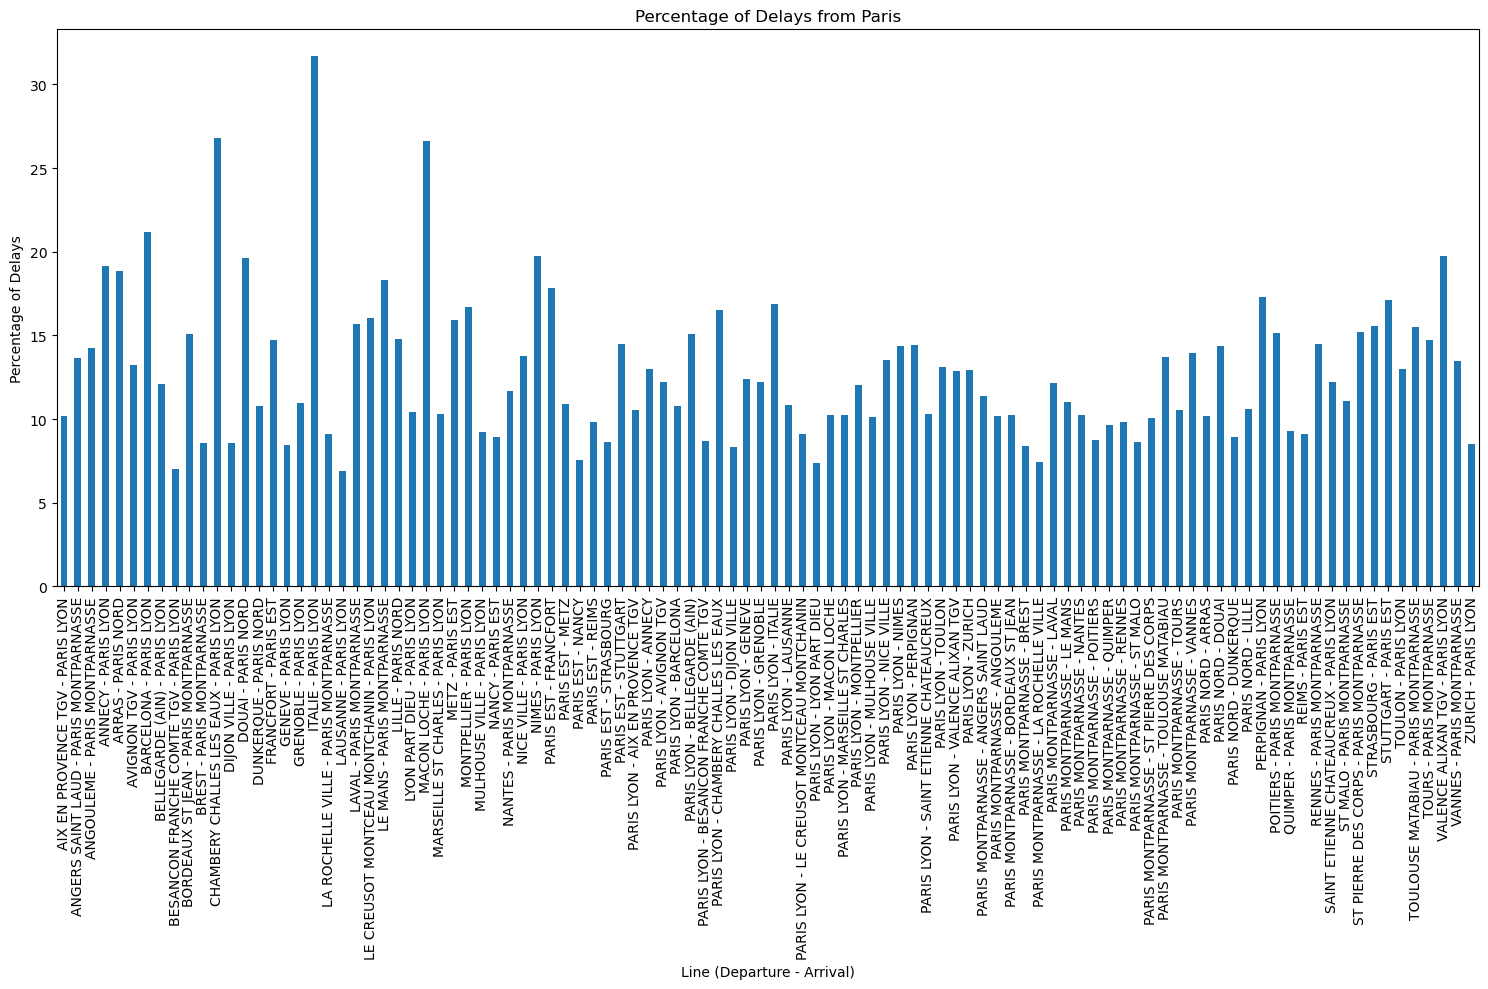

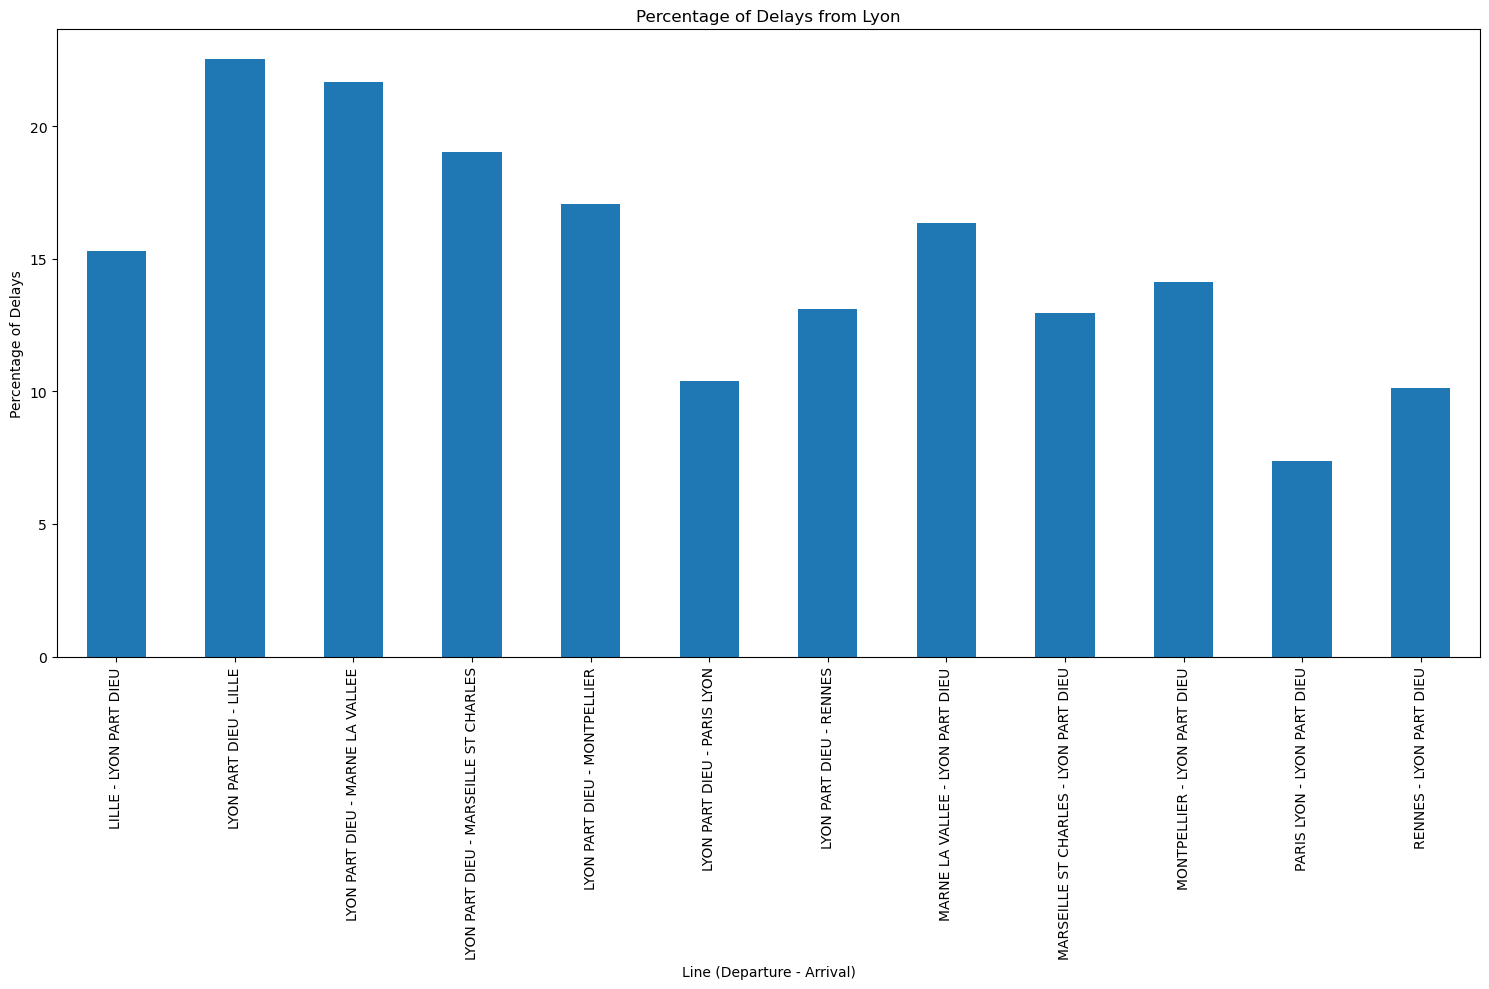

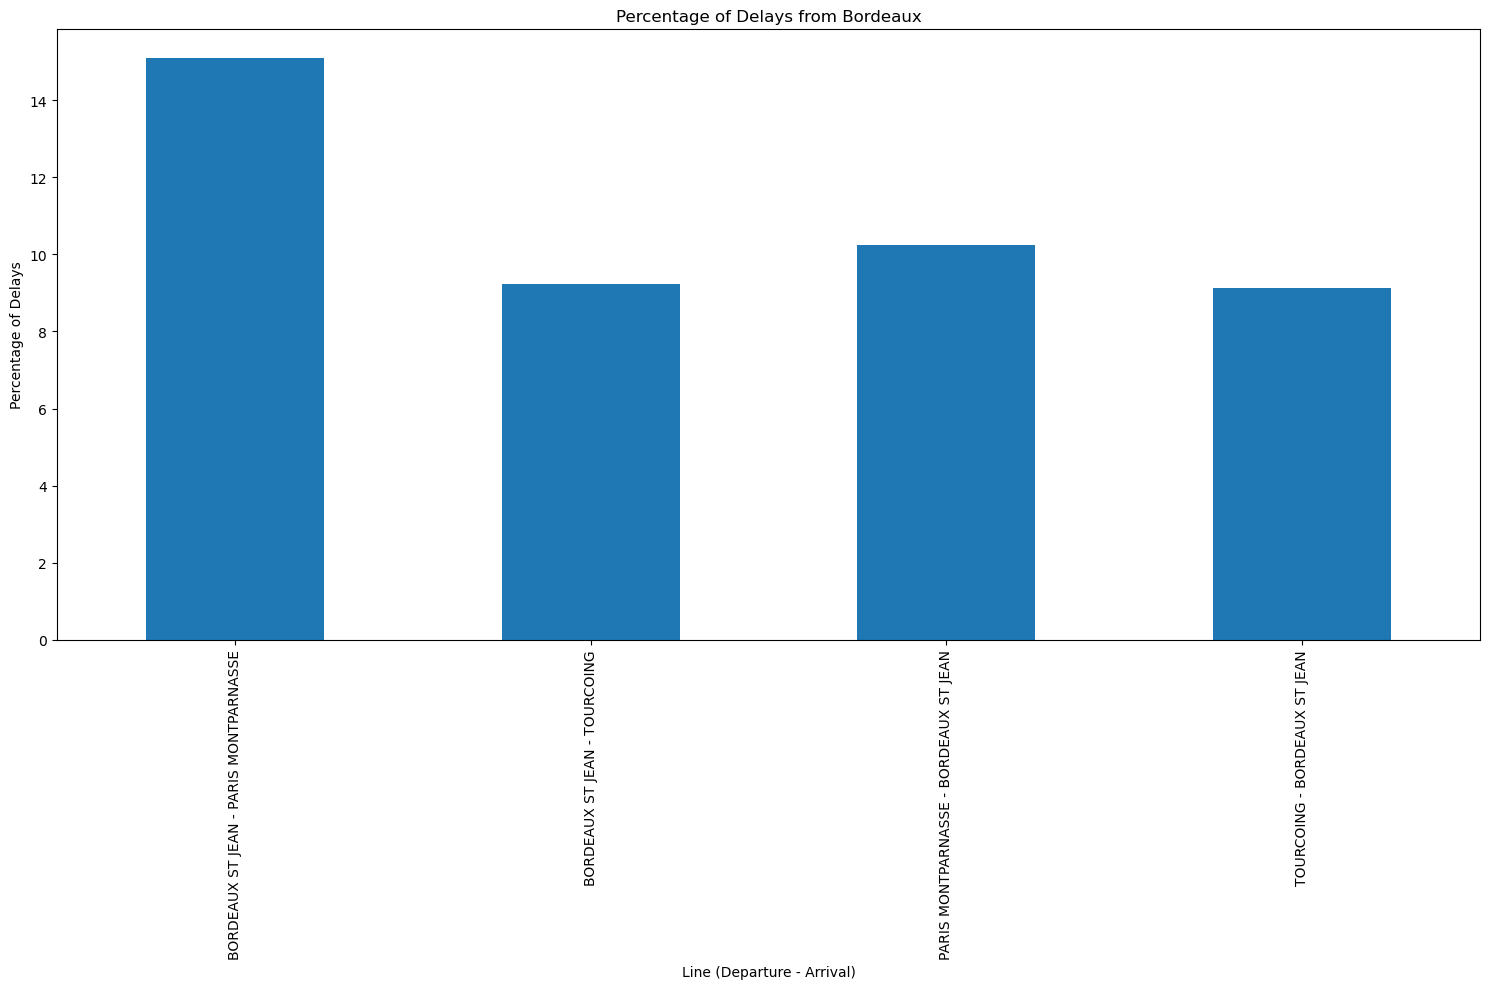

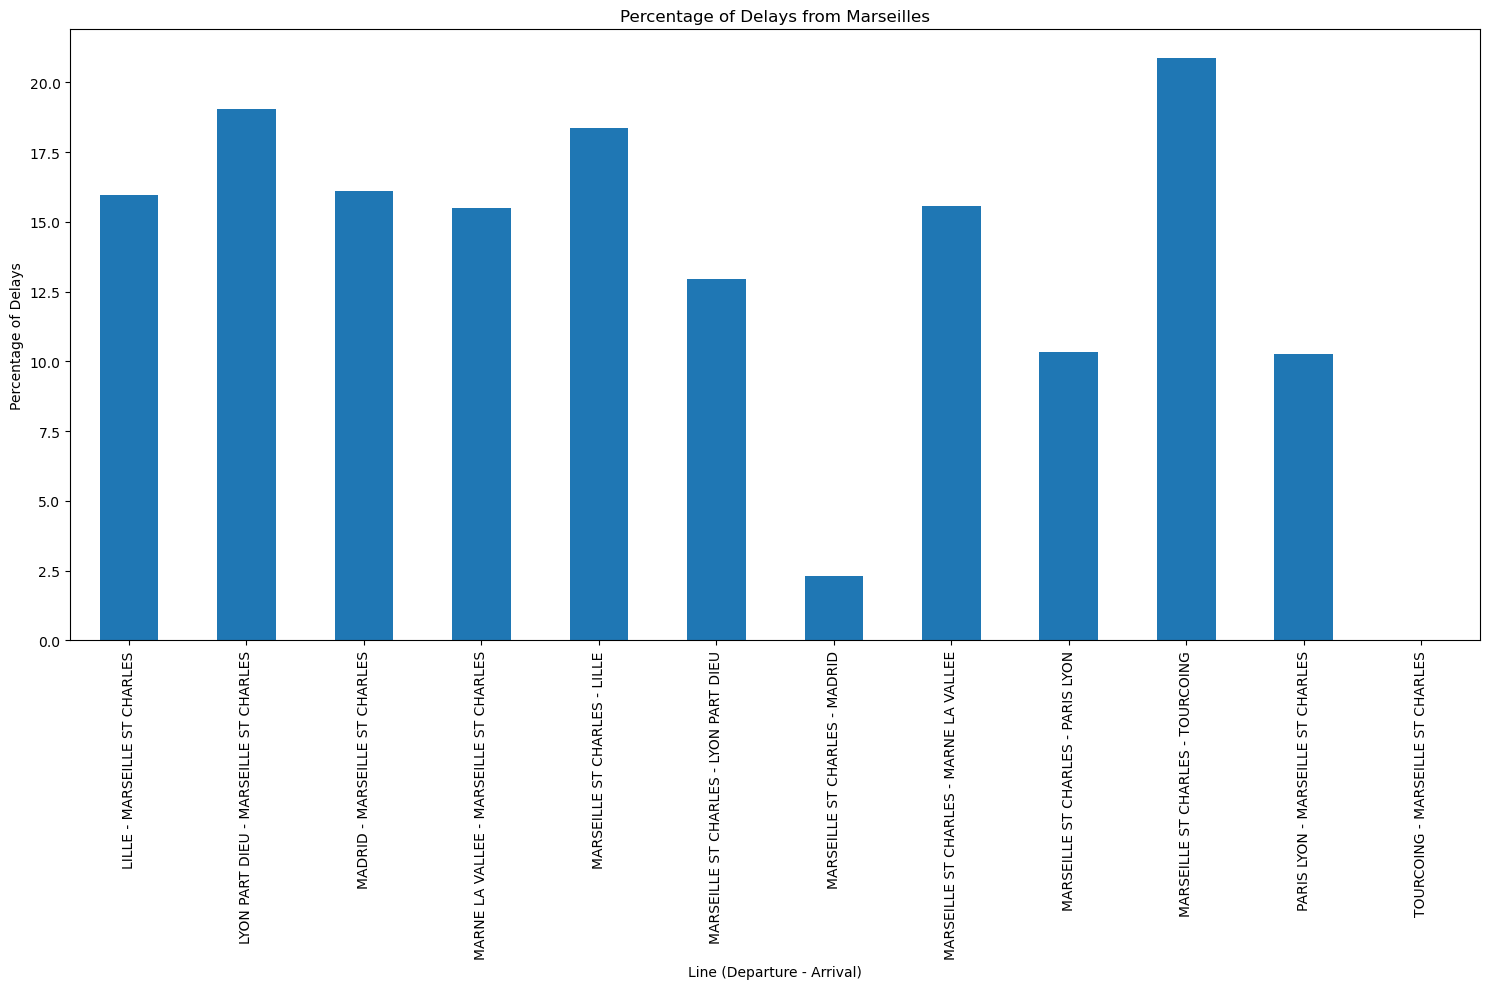

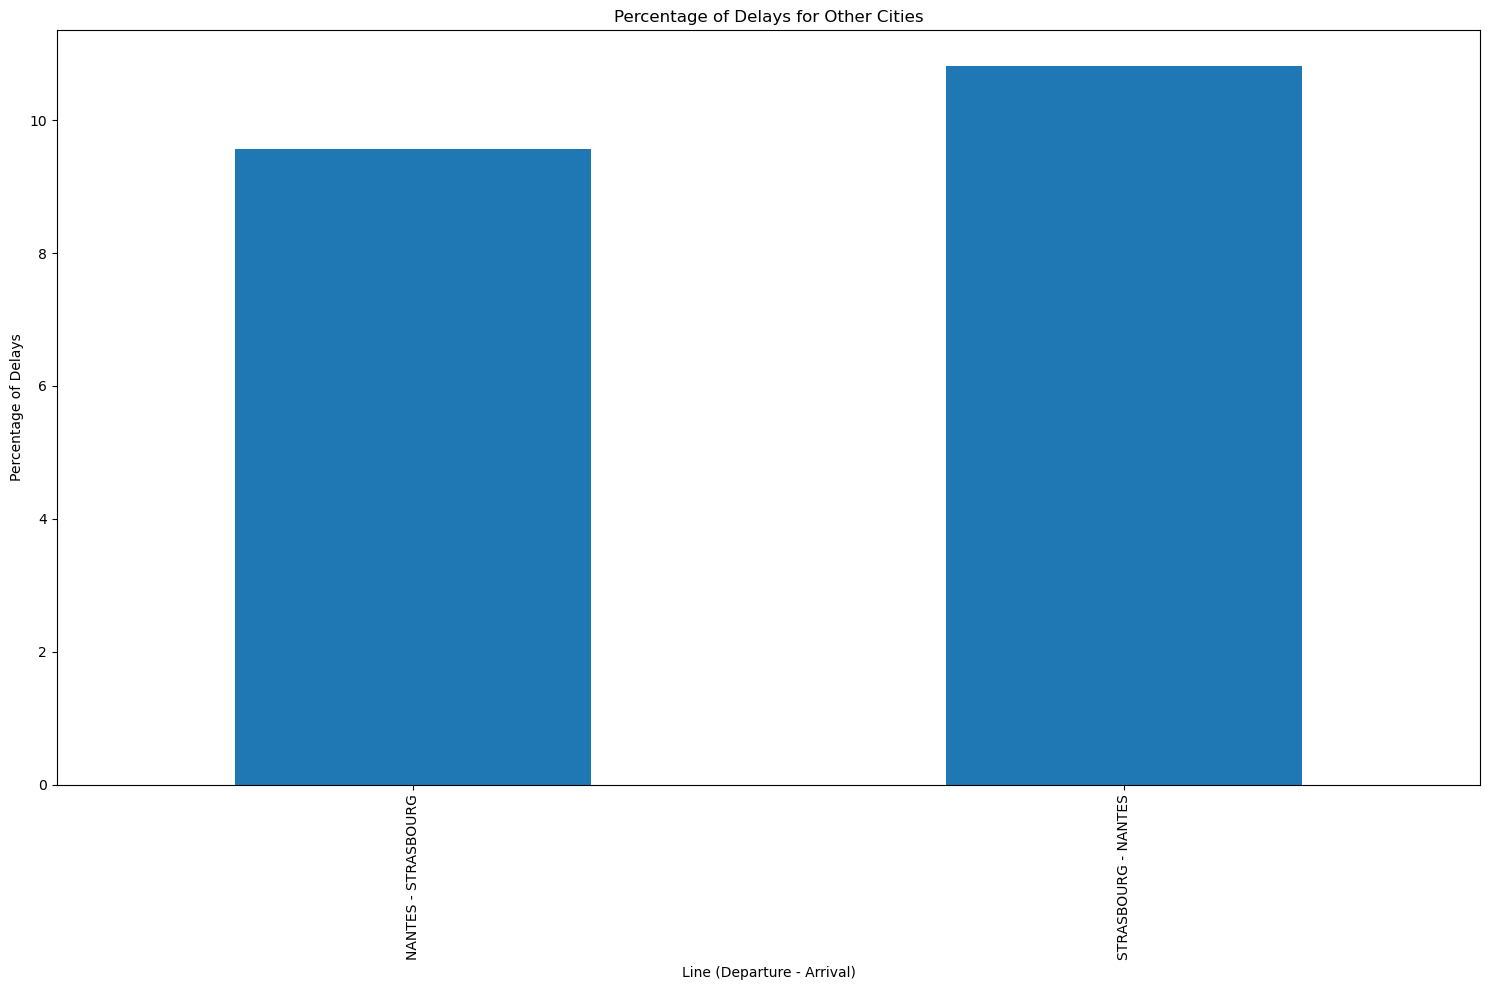

In [70]:
import matplotlib.pyplot as plt

# Adjusting the aggregation to include both the sum of delays and the count of trains
df_grouped = df_sliced.groupby('Line').agg({
    "Nombre de trains en retard à l'arrivée" : 'sum',
    'Nombre de circulations prévues': 'sum'
})

# Calculating the percentage of delayed trains
df_grouped['Percentage of Delays'] = (df_grouped["Nombre de trains en retard à l'arrivée"] / df_grouped['Nombre de circulations prévues']) * 100

# Plot for each city
for city, stations in cities.items():
    pattern = '|'.join(stations)  # Pattern to match stations for the current city
    city_df_grouped = df_grouped[df_grouped.index.str.contains(pattern)]
    
    if not city_df_grouped.empty:
        city_df_grouped['Percentage of Delays'].plot(kind='bar', figsize=(fig_width, fig_height))
        plt.title(f'Percentage of Delays from {city}')
        plt.xlabel('Line (Departure - Arrival)')
        plt.ylabel('Percentage of Delays')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No delay data to plot for {city}")

# Correctly filter for 'Other' cities
known_cities_pattern = '|'.join([station for stations_list in cities.values() for station in stations_list])
other_cities_df_grouped = df_grouped[~df_grouped.index.str.contains(known_cities_pattern)]

# Plotting for 'Other' cities
if not other_cities_df_grouped.empty:
    other_cities_df_grouped['Percentage of Delays'].plot(kind='bar', figsize=(fig_width, fig_height))
    plt.title('Percentage of Delays for Other Cities')
    plt.xlabel('Line (Departure - Arrival)')
    plt.ylabel('Percentage of Delays')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No delay data to plot for 'Other' cities")


In [72]:
# Simple predictor using linear regression, does not differentiate the case where the train has a higher chance not to be late at all.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

# Encoding the 'Line' column (for route)
encoder = LabelEncoder()
df_sliced['Line_encoded'] = encoder.fit_transform(df_sliced['Line'])


X = df_sliced[['Line_encoded', 'Month']]
y = df_sliced["Retard moyen de tous les trains à l'arrivée"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'MSE: {mse}')


# Example: Predicting delay for a specific route and date
route = "PARIS MONTPARNASSE - RENNES"
month = 6  # June

route_encoded = encoder.transform([route])
predicted_delay = model.predict([[route_encoded[0], month]])
print(f"Predicted delay: {predicted_delay[0]} minutes")

MSE: 47.60374182919961
Predicted delay: 2.7375039154218377 minutes


/Users/julianemercoli/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [73]:
# Changing the was we predict: first decide whether the train will be late and then if late, estimate how much

# Predict whether a train will be late
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Group by 'Line' and 'Month', and calculate the delay ratio
df_sliced.groupby(['Line', 'Month'])
df.drop_duplicates(inplace=True)


delay_ratio = df_sliced.groupby(['Line', 'Month']).apply(
    lambda x: (x["Nombre de trains en retard à l'arrivée"]).sum() / (x['Nombre de circulations prévues'] + 1e-8) * 100
).reset_index(name='delay_ratio')

# Add a column with delay ratio back into your main DataFrame
df_sliced = pd.merge(df_sliced, delay_ratio, on=['Line', 'Month'], how='left')
# print('delay_ratio' in df_sliced.columns)
df_sliced.dropna(subset=['Line_encoded', 'Month', 'delay_ratio'], inplace=True) # to remove NaN and invalid data
# print(delay_ratio.head())

# Define a threshold for considering a route-month combination as 'prone to delays'
DELAY_RATIO_THRESHOLD = 0.15  # if more than 15% of trains are delayed, considered the route for this month prone to delay.

# Create a binary target variable based on whether the delay ratio exceeds the threshold
df_sliced['Is_Delay_Prone'] = (df_sliced['delay_ratio'] > DELAY_RATIO_THRESHOLD).astype(int)

# Now, use 'Delay_Ratio' as your sole feature for prediction
X = df_sliced[['delay_ratio']]
y = df_sliced['Is_Delay_Prone']


# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


3036   2020-01-01
3037   2020-01-01
3038   2020-01-01
3039   2020-01-01
3040   2020-01-01
          ...    
8869   2023-12-01
8870   2023-12-01
8871   2023-12-01
8872   2023-12-01
8873   2023-12-01
Name: Date, Length: 5838, dtype: datetime64[ns]
3036    National
3037    National
3038    National
3039    National
3040    National
          ...   
8869    National
8870    National
8871    National
8872    National
8873    National
Name: Service, Length: 5838, dtype: object
3036     ANGERS SAINT LAUD
3037      BORDEAUX ST JEAN
3038                NANTES
3039    PARIS MONTPARNASSE
3040               ST MALO
               ...        
8869    PARIS MONTPARNASSE
8870    PARIS MONTPARNASSE
8871            PARIS NORD
8872            STRASBOURG
8873                 TOURS
Name: Gare de départ, Length: 5838, dtype: object
3036    PARIS MONTPARNASSE
3037    PARIS MONTPARNASSE
3038    PARIS MONTPARNASSE
3039              POITIERS
3040    PARIS MONTPARNASSE
               ...        
8869           

In [62]:
# Example route and month
route_example = "PARIS MONTPARNASSE - RENNES"
month_example = 3  # March

# Calculate a delay_ratio for this route and month
delay_ratio_example = df_sliced[(df_sliced['Line'] == route_example) & (df_sliced['Month'] == month_example)]['delay_ratio'].iloc[0] 
input_features = [[delay_ratio_example]]

# Predict whether if it will be late
## Make the prediction
prediction = classifier.predict(input_features)
prediction_proba = classifier.predict_proba(input_features)

# Output the prediction
print(f"Prediction for {route_example} in month {month_example}: {'Prone to delay' if prediction[0] == 1 else 'Not prone to delay'}")
# Confidence Interval 
print(f"Probability [Not Prone, Prone]: {prediction_proba[0]}")


Prediction for PARIS MONTPARNASSE - RENNES in month 3: Prone to delay
Probability [Not Prone, Prone]: [0. 1.]


/Users/julianemercoli/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/julianemercoli/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [12]:
# If late, predict how much
from sklearn.ensemble import RandomForestRegressor

# Filter the dataset to include only the instances where trains are delayed
delayed_trains = df_sliced[df_sliced["Retard moyen de tous les trains à l'arrivée"] > 0]

# Features for the regression model
X_delayed = delayed_trains[['Line_encoded', 'Month', 'delay_ratio']]  # Assuming these features are relevant
y_delayed = delayed_trains['Retard moyen de tous les trains à l\'arrivée']  # Target variable is the delay amount

# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_delayed, y_delayed, test_size=0.2, random_state=42)

# Train the regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_reg, y_train_reg)


RandomForestRegressor(random_state=42)

In [13]:
# Example: Predict for a specific route and month
route_example = "PARIS MONTPARNASSE - RENNES"  # Assuming you have encoded this route
month_example = 3  # March

delay_ratio_example = df_sliced[(df_sliced['Line'] == route_example) & (df_sliced['Month'] == month_example)]['delay_ratio'].iloc[0] 

# Encode the route if necessary (assuming `encoder` is your LabelEncoder instance)
route_encoded = encoder.transform([route_example])

# Predict whether the train will be late
is_late_prediction = classifier.predict([[delay_ratio_example]])

if is_late_prediction[0] == 1:  # If the train is predicted to be late
    # Predict how much the delay will be
    delay_amount_prediction = regressor.predict([[route_encoded[0], month_example, delay_ratio_example]])
    print(f"The train is predicted to be late by approximately {delay_amount_prediction[0]:.2f} minutes.")
else:
    print("The train is predicted to be on time.")


The train is predicted to be late by approximately 1.81 minutes.


/Users/julianemercoli/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/julianemercoli/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [39]:
print(df_sliced.columns.tolist())

['Date', 'Service', 'Gare de départ', "Gare d'arrivée", 'Durée moyenne du trajet', 'Nombre de circulations prévues', 'Nombre de trains annulés', 'Nombre de trains en retard au départ', 'Retard moyen des trains en retard au départ', 'Retard moyen de tous les trains au départ', "Nombre de trains en retard à l'arrivée", "Retard moyen des trains en retard à l'arrivée", "Retard moyen de tous les trains à l'arrivée", 'Nombre trains en retard > 15min', 'Retard moyen trains en retard > 15 (si liaison concurrencée par vol)', 'Nombre trains en retard > 30min', 'Nombre trains en retard > 60min', 'Prct retard pour causes externes', 'Prct retard pour cause infrastructure', 'Prct retard pour cause gestion trafic', 'Prct retard pour cause matériel roulant', 'Prct retard pour cause gestion en gare et réutilisation de matériel', 'Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)', 'Month', 'Line', 'Line_encoded', 'level_2', 'delay_ratio', 'Is_Delay_Prone']
